In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [112]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/HPG Historical Data.csv', sep=";")
df1=df.reset_index()['Price']

In [113]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [114]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [115]:
print(train_data.shape, test_data.shape)

(876, 1) (376, 1)


In [116]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [117]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [118]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1 ,X_test.shape[1])

In [119]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(860, 1, 15)
(860,)
(360, 1, 15)
(360,)


In [120]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,15)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [121]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 51s 144ms/step - loss: 0.2902 - val_loss: 0.0017
Epoch 2/100
14/14 [==============================] - 0s 18ms/step - loss: 0.1510 - val_loss: 0.0082
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0185 - val_loss: 0.0278
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 0.0179
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0219
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0041 - val_loss: 0.0164
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0032 - val_loss: 0.0151
Epoch 8/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0126
Epoch 9/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0110
Epoch 10/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.009

In [122]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [123]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [124]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 11.782227189688793


In [125]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 15
i = 0

while i < 30:
    if len(temp_input) > 100:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-15:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, 1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.10552571 0.10843109 0.10456639 0.10407302 0.10456639 0.12674049
 0.12819318 0.12336915 0.12290319 0.12432847 0.12578116 0.1344699
 0.13493586 0.13784125 0.12723386]
0 day output [[0.15024905]]
1 day input [0.10843109 0.10456639 0.10407302 0.10456639 0.12674049 0.12819318
 0.12336915 0.12290319 0.12432847 0.12578116 0.1344699  0.13493586
 0.13784125 0.12723386 0.15024905]
1 day output [[0.15589847]]
2 day input [0.10456639 0.10407302 0.10456639 0.12674049 0.12819318 0.12336915
 0.12290319 0.12432847 0.12578116 0.1344699  0.13493586 0.13784125
 0.12723386 0.15024905 0.15589847]
2 day output [[0.16187242]]
3 day input [0.10407302 0.10456639 0.12674049 0.12819318 0.12336915 0.12290319
 0.12432847 0.12578116 0.1344699  0.13493586 0.13784125 0.12723386
 0.15024905 0.15589847 0.16187242]
3 day output [[0.1670739]]
4 day input [0.10456639 0.12674049 0.12819318 0.12336915 0.12290319 0.12432847
 0.12578116 0.1344699  0.13493586 0.13784125 0.12723386 0.15024905
 0.15589847 0.161872

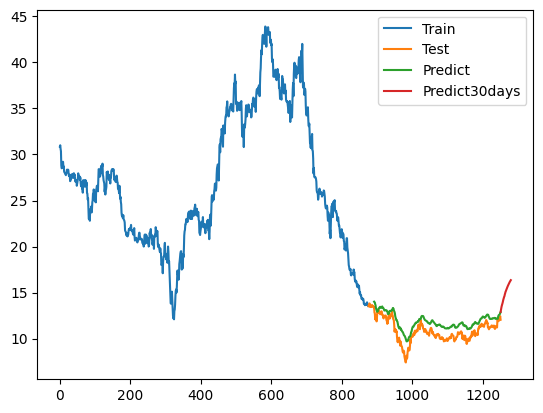

In [126]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+16, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [133]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 15
i = 0

while i < 60:
    if len(temp_input) > 15:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-15:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, 1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.10552571 0.10843109 0.10456639 0.10407302 0.10456639 0.12674049
 0.12819318 0.12336915 0.12290319 0.12432847 0.12578116 0.1344699
 0.13493586 0.13784125 0.12723386]
0 day output [[0.15024905]]
1 day input [0.10843109 0.10456639 0.10407302 0.10456639 0.12674049 0.12819318
 0.12336915 0.12290319 0.12432847 0.12578116 0.1344699  0.13493586
 0.13784125 0.12723386 0.15024905]
1 day output [[0.15589847]]
2 day input [0.10456639 0.10407302 0.10456639 0.12674049 0.12819318 0.12336915
 0.12290319 0.12432847 0.12578116 0.1344699  0.13493586 0.13784125
 0.12723386 0.15024905 0.15589847]
2 day output [[0.16187242]]
3 day input [0.10407302 0.10456639 0.12674049 0.12819318 0.12336915 0.12290319
 0.12432847 0.12578116 0.1344699  0.13493586 0.13784125 0.12723386
 0.15024905 0.15589847 0.16187242]
3 day output [[0.1670739]]
4 day input [0.10456639 0.12674049 0.12819318 0.12336915 0.12290319 0.12432847
 0.12578116 0.1344699  0.13493586 0.13784125 0.12723386 0.15024905
 0.15589847 0.161872

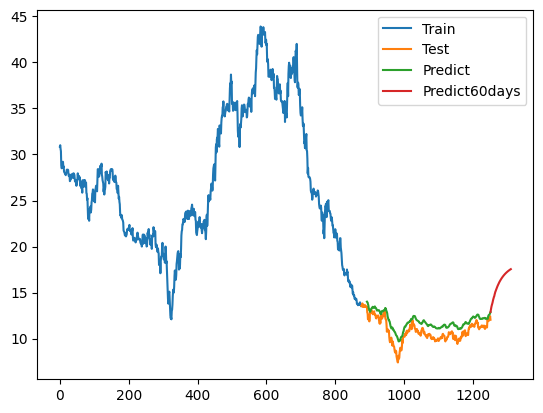

In [134]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = pd.RangeIndex(start=train_size + 16, stop=train_size + test_size, step=1)
plt.plot(pred_data_index, y_pred, label='Predict')

predict_data_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 59, step=1)

lst_output_flat = np.array(lst_output).reshape(-1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output_flat.reshape(-1, 1)), label='Predict60days')

plt.legend()
plt.show()

In [139]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 15
i = 0

while i < 90:
    if len(temp_input) > 15:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-15:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1,1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1,1 ,n_steps))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.10552571 0.10843109 0.10456639 0.10407302 0.10456639 0.12674049
 0.12819318 0.12336915 0.12290319 0.12432847 0.12578116 0.1344699
 0.13493586 0.13784125 0.12723386]
0 day output [[0.15024905]]
1 day input [0.10843109 0.10456639 0.10407302 0.10456639 0.12674049 0.12819318
 0.12336915 0.12290319 0.12432847 0.12578116 0.1344699  0.13493586
 0.13784125 0.12723386 0.15024905]
1 day output [[0.15589847]]
2 day input [0.10456639 0.10407302 0.10456639 0.12674049 0.12819318 0.12336915
 0.12290319 0.12432847 0.12578116 0.1344699  0.13493586 0.13784125
 0.12723386 0.15024905 0.15589847]
2 day output [[0.16187242]]
3 day input [0.10407302 0.10456639 0.12674049 0.12819318 0.12336915 0.12290319
 0.12432847 0.12578116 0.1344699  0.13493586 0.13784125 0.12723386
 0.15024905 0.15589847 0.16187242]
3 day output [[0.1670739]]
4 day input [0.10456639 0.12674049 0.12819318 0.12336915 0.12290319 0.12432847
 0.12578116 0.1344699  0.13493586 0.13784125 0.12723386 0.15024905
 0.15589847 0.161872

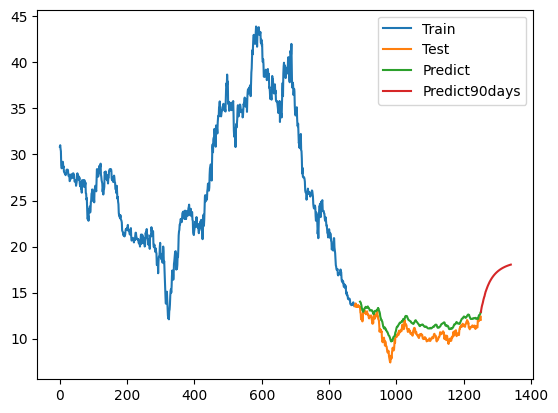

In [140]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Chỉ số cho dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Chỉ số cho dữ liệu dự đoán
pred_data_index = pd.RangeIndex(start=train_size + 16, stop=train_size + test_size, step=1)
plt.plot(pred_data_index, y_pred, label='Predict')

# Chỉ số cho dữ liệu dự báo 90 ngày
predict_data_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 89, step=1)

# Chuyển đổi lst_output thành dạng phù hợp
lst_output_flat = np.array(lst_output).reshape(-1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output_flat.reshape(-1, 1)), label='Predict90days')

# Hiển thị đồ thị
plt.legend()
plt.show()